Postavljanje okruženja

In [1]:
!pip install pandas openpyxl
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Diplomski/diplomski/datasets/amazon/Amazon_historical_data.csv'

Mounted at /content/drive


Postavljanje dataseta:

*   Dataset sadržava vrijednosti za svaki radni dan burze od 2015 do 2020
* Svaki redak sadržava datum i cijenu dionice na taj dan

In [2]:
data = pd.read_csv(file_path)

features_to_shift = [
  "yesterday_price"
]

data['yesterday_price'] = data['Adj_Close']
data[features_to_shift] = data[features_to_shift].shift(1)
data['price_diff'] = data['yesterday_price'] -  data['Adj_Close']

data = data[(data['Date'] >= '2015-01-01') & (data['Date'] <= '2020-01-01')]
features_to_keep = ["Date","Adj_Close", 'yesterday_price', 'price_diff']
data = data[features_to_keep]
data = data.reset_index(drop=True)
data

,Date,Adj_Close,yesterday_price,price_diff
0,2015-01-02,15.426000,15.517500,0.091500
1,2015-01-05,15.109500,15.426000,0.316500
2,2015-01-06,14.764500,15.109500,0.345000
3,2015-01-07,14.921000,14.764500,-0.156500
4,2015-01-08,15.023000,14.921000,-0.102000
...,...,...,...,...
1253,2019-12-24,89.460503,89.650002,0.189499
1254,2019-12-26,93.438499,89.460503,-3.977996
1255,2019-12-27,93.489998,93.438499,-0.051499
1256,2019-12-30,92.344498,93.489998,1.145500


Tražimo optimalnu vrijednost alfe za ES model

In [3]:
alpha_values = np.linspace(0.01, 0.99, 50)

tscv = TimeSeriesSplit(n_splits=5)

best_alpha = None
best_error = float('inf')

for alpha in alpha_values:
    errors = []
    for train_index, val_index in tscv.split(data):
        train_set, val_set = data.iloc[train_index], data.iloc[val_index]
        model = SimpleExpSmoothing(train_set['Adj_Close'].values).fit(smoothing_level=alpha, optimized=False)
        forecast = model.forecast(len(val_set))

        error = mean_squared_error(val_set['Adj_Close'], forecast)
        errors.append(error)

    avg_error = np.mean(errors)

    if avg_error < best_error:
        best_error = avg_error
        best_alpha = alpha

print("Best alpha:", best_alpha)

Best alpha: 0.99


# Walk forward validation
Time-series algoritmi rade na način da predviđaju buduću cijenu na temelju prošlih. Tu predviđenu cijenu spremamo u polje te ponavljamo isti postupak za idući dan itd...

In [4]:
#train_size = int(len(data) * 0.8)
#
#actual_values = []
#predicted_values = []
#
#for i in range(train_size, len(data)):
#    train_data = data.iloc[:i]
#    test_data = data.iloc[i:i+1]
#
#    alpha = 0.99
#    model = SimpleExpSmoothing(train_data['Adj_Close'].values).fit(smoothing_level=alpha, optimized=False)
#
#    forecast = model.forecast(steps=1)
#
#    actual_values.append(test_data['Adj_Close'].values[0])
#    predicted_values.append(forecast[0])

In [5]:
def walk_forward_validation(data, train_size):
    actual_values = []
    predicted_values = []
    rmse_values = []
    for i in range(train_size, len(data)):
        train_data = data.iloc[:i]
        test_data = data.iloc[i:i+1]
        alpha = 0.6
        model = SimpleExpSmoothing(train_data['Adj_Close'].values).fit(smoothing_level=alpha, optimized=False)
        forecast = model.forecast(steps=1)

        actual = test_data['price_diff'].values[0]
        actual_values.append(test_data['price_diff'].values[0])

        prediction = test_data['yesterday_price'].values[0] - forecast
        prediction = [prediction]
        actual = [actual]
        predicted_values.append(prediction[0])
        mse = mean_squared_error(actual, prediction)
        rmse = np.sqrt(mse)
        rmse_values.append(rmse)

    return predicted_values, actual_values , rmse_values

train_size = int(len(data) * 0.8)

predicted_values, actual_values, rmse_values = walk_forward_validation(data, train_size)

Grafički prikaz

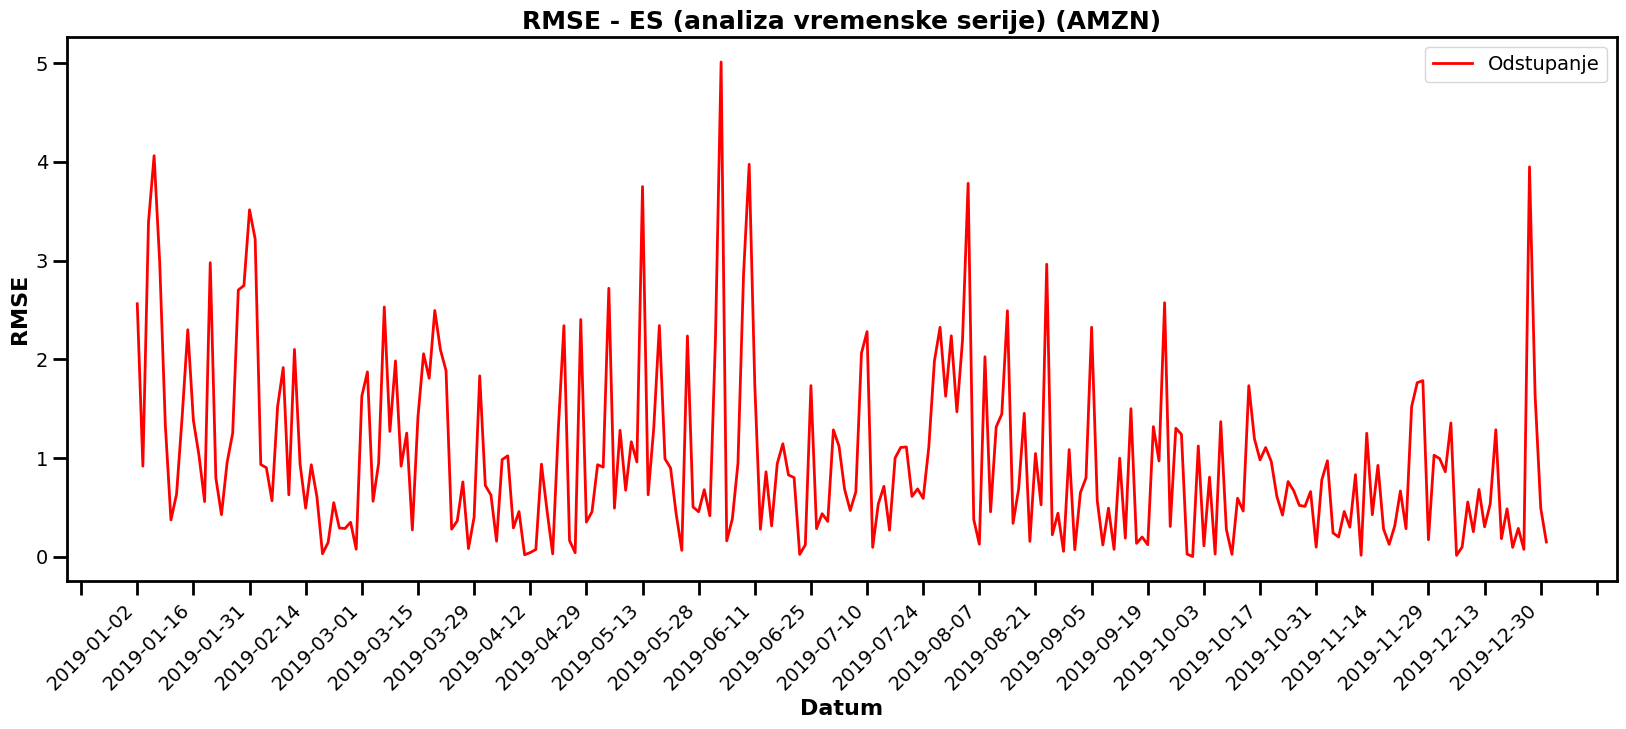

In [6]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot the RMSE values with increased line thickness
plt.plot(plot_data["Date"], rmse_values, label='Odstupanje', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('RMSE', fontsize=16, fontweight='bold')
plt.title('RMSE - ES (analiza vremenske serije) (AMZN)', fontsize=18, fontweight='bold')

# Customize the legend to make the label fatter and more prominent
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


In [7]:
excel = {
    'Date': plot_data["Date"],
    'RMSE': rmse_values
}
df = pd.DataFrame(excel)

# Export to an Excel file
excel_file_path = 'ES_time_series_GOOG_rmse_values.xlsx'
df.to_excel(excel_file_path, index=False)

mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
print(rmse)

1.3587935207022548


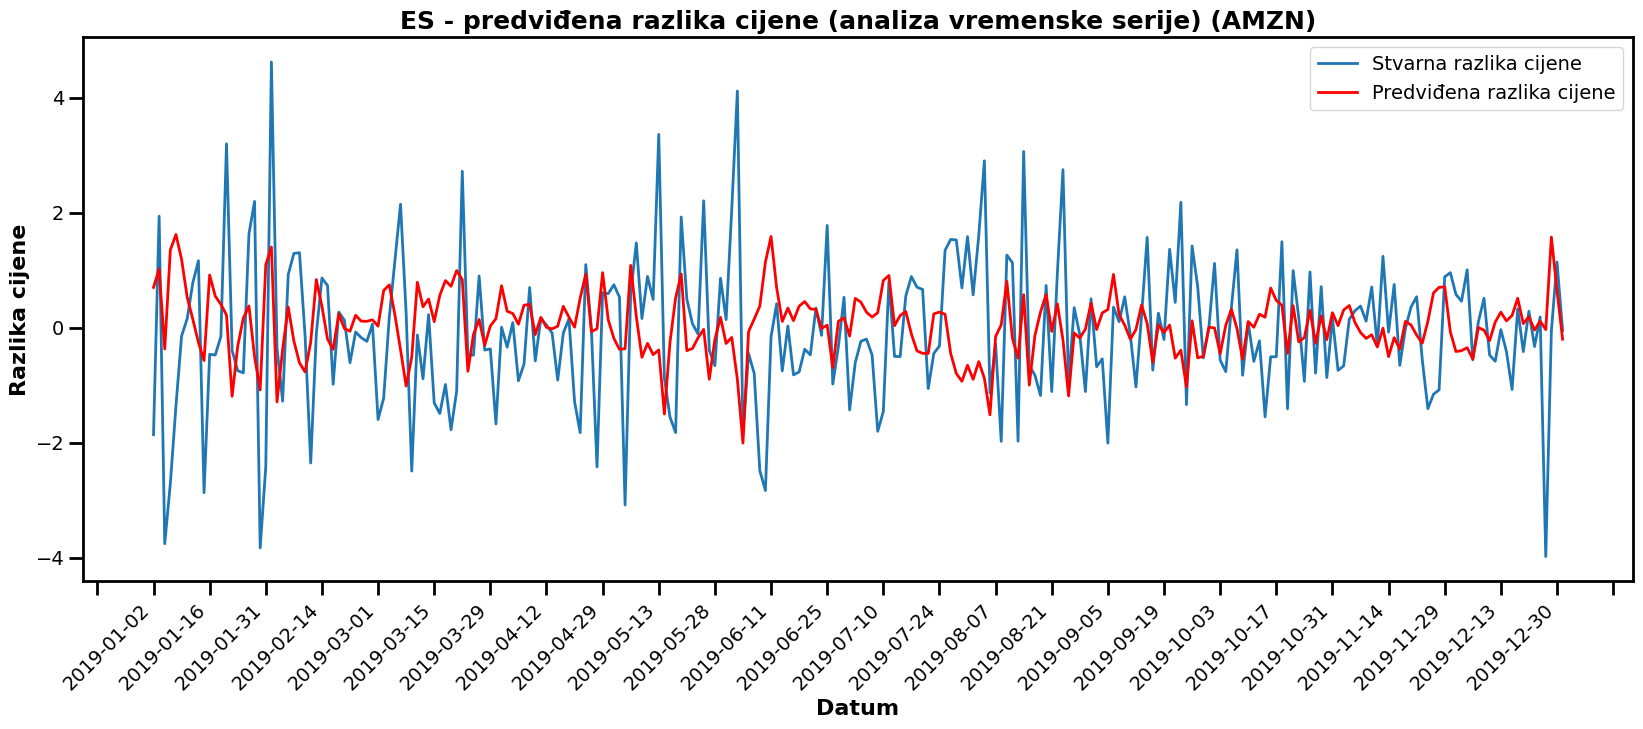

In [8]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot actual and predicted price differences with increased line thickness
plt.plot(plot_data["Date"], actual_values, label='Stvarna razlika cijene', linewidth=2)
plt.plot(plot_data["Date"], predicted_values, label='Predviđena razlika cijene', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Razlika cijene', fontsize=16, fontweight='bold')
plt.title('ES - predviđena razlika cijene (analiza vremenske serije) (AMZN)', fontsize=18, fontweight='bold')

# Customize the legend to make the labels fatter and more prominent
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


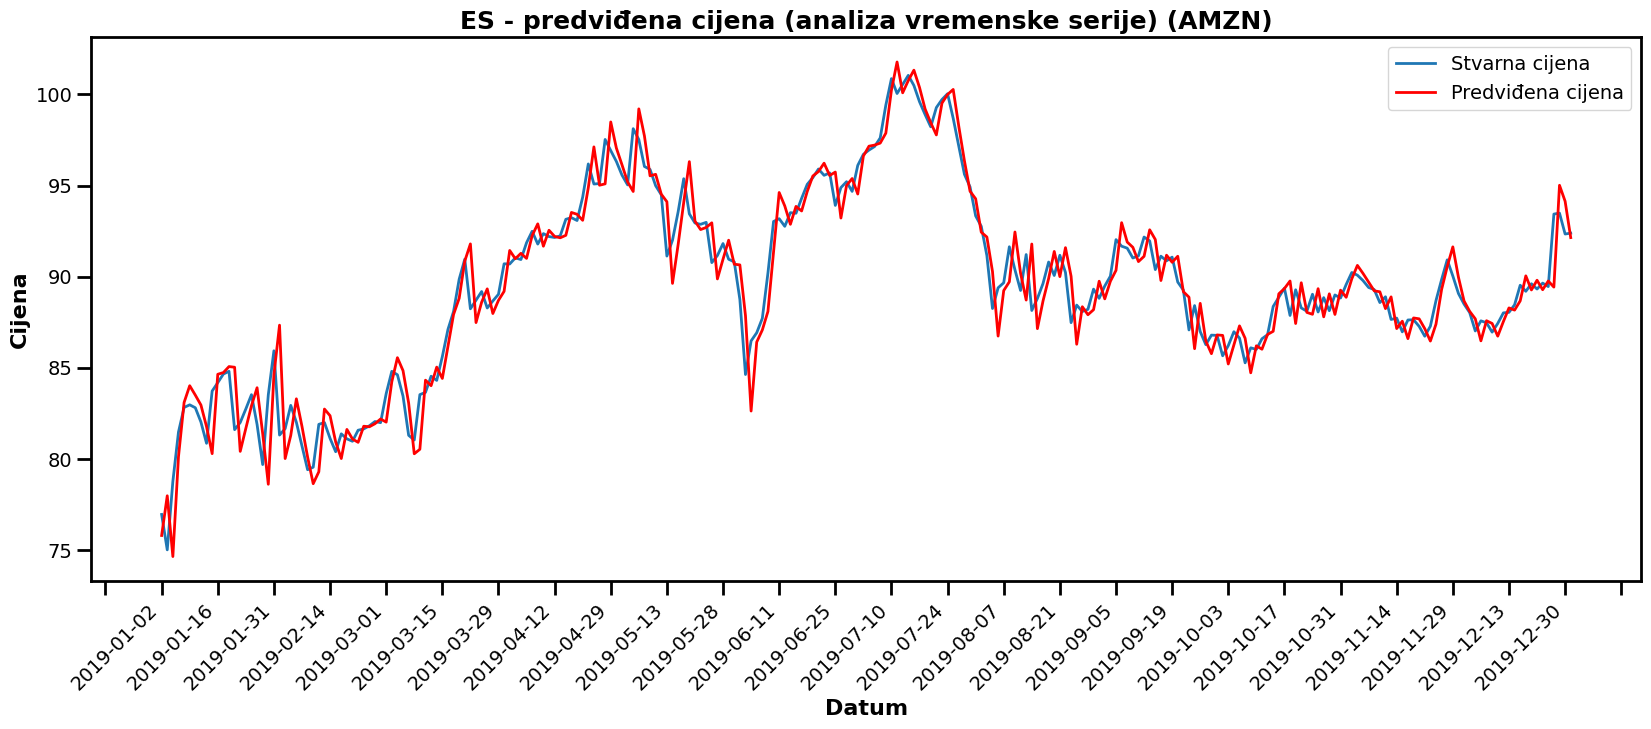

In [9]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plot_data["predicted_diff"] = predicted_values
plot_data["Predicted_price"] = plot_data["yesterday_price"] + plot_data["predicted_diff"]

plt.figure(figsize=(20, 8))

# Plot the actual and predicted prices with increased line thickness
plt.plot(plot_data["Date"], plot_data["Adj_Close"], label='Stvarna cijena', linewidth=2)
plt.plot(plot_data["Date"], plot_data["Predicted_price"], label='Predviđena cijena', color='red', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Cijena', fontsize=16, fontweight='bold')
plt.title('ES - predviđena cijena (analiza vremenske serije) (AMZN)', fontsize=18, fontweight='bold')

# Customize the legend to make the labels fatter and more prominent
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()
